# Import required libraries

In [1]:
import sys
import pprint
import pandas as pd
import numpy as np
from scipy.special import softmax

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
import sklearn
import os

import shutil

from os import listdir
from os.path import isfile, join

import time

In [2]:
# Setting path for importing required functions for data processing

sys.path.append("/home/jupyter/sonam/adhd_nlp/final_notebook_folder/data_processing")
sys.path.append("/home/jupyter/sonam/adhd_nlp/final_notebook_folder/data_processing")

In [3]:
# Functions required for data processing

import final_process_text
import final_transform_textfiles

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 300)
pd.set_option('display.max_columns', 100)

In [5]:
# using simpletransformer ai library

from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Import Data

In [7]:
label_of_interest = "BT_yn"

In [9]:
originalTextData = final_transform_textfiles.extractOriginalText("/home/jupyter/data/cohort_2to6/Text files/combined_text")
print(originalTextData.shape)
annotatedXMIs = final_transform_textfiles.extractXMIAnnotation("/home/jupyter/data/cohort_2to6/XMI files/combined")
print(annotatedXMIs.shape)

(424, 2)
(424, 73)


In [10]:
type(originalTextData)

pandas.core.frame.DataFrame

In [11]:
#originalTextData.tail(2)

In [12]:
type(annotatedXMIs)

pandas.core.frame.DataFrame

In [13]:
#annotatedXMIs.tail(2)

In [14]:
print(annotatedXMIs['anon_id'].value_counts(ascending=False))

10040    2
45167    1
41514    1
24638    1
18229    1
        ..
12521    1
53188    1
19496    1
62944    1
31727    1
Name: anon_id, Length: 423, dtype: int64


# Data Processing 

In [15]:
# Deleting last row from 'originalTextData' and 'annotatedXMIS' dataframe as the last row is just checpoint roe mentioned above
# for  ANNON_ID 10040 and hence deleting it would result in final cohort size of 432 as needed for new results.

In [16]:
# dropping last row in text and XMI pandas dataframe.
#originalTextData.drop(originalTextData.tail(-1).index,inplace=True)
# annotatedXMIs.drop(annotatedXMIs.tail(-1).index,inplace=True)

originalTextData = originalTextData[:-1]
annotatedXMIs = annotatedXMIs[:-1]

print(originalTextData.shape)
print(annotatedXMIs.shape)

(423, 2)
(423, 73)


In [17]:
# creating single label_of_interest "BT_yn" column using other columns

annotatedXMIs['BT_yn'] = np.where((annotatedXMIs['Counsel_Parent_BT'] == 1) | (annotatedXMIs['Counsel_Handout_BT'] == 1) | (annotatedXMIs['Refer_Parent_BT'] == 1) | (annotatedXMIs['Refer_School_BT'] == 1), 1, 0)
annotatedXMIs['BT_yn'].value_counts()

0    303
1    120
Name: BT_yn, dtype: int64

In [20]:
# merging data from both files 
data = originalTextData.merge(annotatedXMIs, on = "file", how = "right")

In [21]:
# using imported function sectionize() for processing notes text data

data['extractText'] = data['note_des'].apply(lambda x: final_process_text.sectionize(x)[1])

In [22]:
# using imported function clean_text() for processing notes text data

data['extractText'] = data['extractText'].apply(lambda x: final_process_text.clean_text(x))

In [23]:
data = data.loc[:, ['extractText',label_of_interest]]\
       .rename(columns = {'extractText':'text',
                          label_of_interest: 'label'})

In [24]:
X = data.loc[:, 'text']
y = data.loc[:, 'label']

# Split the Data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 117, stratify = y)
X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_train, y_train, test_size = 0.3, random_state = 117, stratify = y_train)

In [26]:
val_train = pd.concat([X_val_train, y_val_train], axis = 1)
val_test = pd.concat([X_val_test, y_val_test], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

#test.head()

#Checking the final size for train, validation and test set

In [27]:
X_val_train.shape

(207,)

In [28]:
X_val_test.shape

(89,)

In [29]:
test.shape

(127, 2)

# Single Run

In [30]:
# setting different parameters for training the transformer model

model_args = ClassificationArgs()
batch_size = 8
steps_per_epoch = np.ceil(val_train.shape[0]/batch_size)
model_args.num_train_epochs = 30

model_args.eval_batch_size = batch_size
model_args.train_batch_size = batch_size
model_args.manual_seed = 117

model_args.evaluate_during_training_steps = steps_per_epoch
model_args.evaluate_during_training_verbose = True
model_args.max_seq_length = 512
model_args.learning_rate = 0.00008	

model_args.save_model_every_epoch = False
model_args.save_eval_checkpoints = False
model_args.save_steps = -1
model_args.logging_steps = steps_per_epoch

model_args.overwrite_output_dir = True
model_args.manual_seed = 117
model_args.evaluate_during_training = True

model_args.best_model_dir = 'final_biobertbest_model_dir_new_cohort'
model_args.output_dir = 'final_biobert_output_dir_new_cohort'
model_args.tensorboard_dir = 'final_biobert_tensorboard_runs_new_cohort'

In [31]:
model = ClassificationModel("bert", "emilyalsentzer/Bio_ClinicalBERT", args=model_args, use_cuda = True, num_labels = 2)

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [32]:
# training the model

start = time.time()
model.train_model(val_train, f1 = f1_score, eval_df = val_test)
end = time.time()
print(end - start)



409.38512420654297


# Evaluation of the trained model

#Evaluate on Validation set (89 samples)

In [33]:

result, model_outputs, wrong_predictions = model.eval_model(val_test, f1 = f1_score, 
                                                            recall = sklearn.metrics.recall_score,
                                                            precision = sklearn.metrics.precision_score,
                                                            auc = sklearn.metrics.roc_auc_score,
                                                            accuracy = sklearn.metrics.accuracy_score)
result

{'mcc': 0.52852868908695,
 'tp': 14,
 'tn': 59,
 'fp': 5,
 'fn': 11,
 'auroc': 0.76,
 'auprc': 0.7235928012436937,
 'f1': 0.6363636363636364,
 'recall': 0.56,
 'precision': 0.7368421052631579,
 'auc': 0.7409375,
 'accuracy': 0.8202247191011236,
 'eval_loss': 1.3299520648154914}

In [34]:
len(wrong_predictions)

16

In [35]:
# saving misclassified samples for validation set in file
with open('/home/jupyter/sonam/final_result_files/final_val_misclassification_new_cohort.txt', mode='wt', encoding='utf-8') as myfile:
    list=["index", "truth", "error","tokenLength", "text"]
    myfile.writelines(str(list));
    myfile.writelines("\n");
    for x in range(len(wrong_predictions)): 
        list=[];
        list.append(x+1);
        truth=wrong_predictions[x].label;
        list.append(truth);
        if truth==1: list.append("fn")
        elif truth==0: list.append("fp")
        list.append(len(model.tokenizer(wrong_predictions[x].text_a)['input_ids']));
        list.append(wrong_predictions[x].text_a);
        myfile.writelines(str(list));
        myfile.writelines("\n");
myfile.close

<function TextIOWrapper.close()>

#Evaluate on Test set (127 samples)

In [36]:
result, model_outputs, wrong_predictions = model.eval_model(test, f1 = f1_score,  
                                                            recall = sklearn.metrics.recall_score,
                                                            precision = sklearn.metrics.precision_score,
                                                            auc = sklearn.metrics.roc_auc_score,
                                                           accuracy = sklearn.metrics.accuracy_score)


predictions, probabilities = model.predict(test['text'].tolist())
test['predictions'] = predictions
test['probabilities'] = [x[1] for x in np.array([softmax(element) for element in probabilities])]
result

{'mcc': 0.7400140310351278,
 'tp': 26,
 'tn': 88,
 'fp': 3,
 'fn': 10,
 'auroc': 0.8728632478632479,
 'auprc': 0.8303792904731615,
 'f1': 0.7999999999999999,
 'recall': 0.7222222222222222,
 'precision': 0.896551724137931,
 'auc': 0.8446275946275946,
 'accuracy': 0.8976377952755905,
 'eval_loss': 0.9141775393650278}

In [37]:
# print(type(probabilities))
# print(probabilities.shape)
# print(probabilities[0])
# test['probabilities']

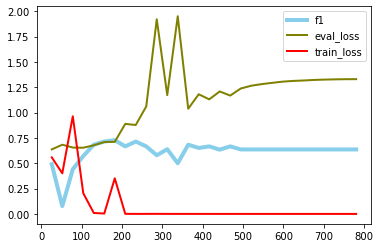

In [38]:
# Get the eval_loss, f1_score curve

curves = pd.read_csv("/home/jupyter/sonam/adhd_nlp/final_notebook_folder/final_biobert_output_dir_new_cohort/training_progress_scores.csv")
import matplotlib.pyplot as plt
plt.plot( 'global_step', 'f1', data=curves,  markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'global_step', 'eval_loss', data=curves, marker='', color='olive', linewidth=2)
plt.plot( 'global_step', 'train_loss', data=curves, marker='', color='red', linewidth=2)
plt.legend()

#Getting precision, recall, thresholds metrics for test set and calculating threshold fi score.

In [39]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(test['label'], test['probabilities'])
precision = precision[:-1]
recall = recall[:-1]
thresholdDF = pd.DataFrame(data = {'precision': precision, 'recall': recall, 'thresholds':thresholds})
thresholdDF['f1_score'] = 2*(thresholdDF['precision']*thresholdDF['recall'])/(thresholdDF['precision'] + thresholdDF['recall'])

In [40]:
max(thresholdDF['f1_score'])

0.7999999999999999

In [41]:
print("_______________________________________________________________________________________________________________")

_______________________________________________________________________________________________________________
